In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np # Matrix Operations (Matlab of Python)
import pandas as pd # Work with Datasources
import matplotlib.pyplot as plt # Drawing Library

from PIL import Image

import torch # Like a numpy but we could work with GPU by pytorch library
import torch.nn as nn # Nural Network Implimented with pytorch
import torchvision # A library for work with pretrained model and datasets

from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

import glob
import os

get_ipython().magic('matplotlib inline')

image_size = (100, 100)
image_row_size = image_size[0] * image_size[1]



In [2]:
class CatDogDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
       
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
       
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        return im, classCategory



In [3]:

#Define Transoformation And Augmentation
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                                transforms.Resize(image_size), 
                                transforms.Grayscale(),
                                transforms.ToTensor(), 
                                transforms.Lambda(lambda x: x.repeat(3,1,1)),
                                transforms.Normalize(mean, std)])



In [4]:

# #Display Sample Image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="plasma")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
#Create Dataset
path    = '/home/aims/aims-courses/Deep learning/visualizing_model_tensorboard/data1/train'
dataset = CatDogDataset(path, transform=transform)


path1    = '/home/aims/aims-courses/Deep learning/visualizing_model_tensorboard/data1/val'
test1 = CatDogDataset(path1, transform=transform)

In [6]:
dataset.classes

['dog', 'cat']

In [67]:
#Create DataLoader
shuffle     = True
batch_size  = 8
num_workers = 0
dataloader  = DataLoader(dataset=dataset, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)

shuffle     = True
batch_size  = 8
num_workers = 0
testloader  = DataLoader(dataset=test1, 
                         shuffle=shuffle, 
                         batch_size=batch_size, 
                         num_workers=num_workers)
# In[8]:


i = 0
for i, (X,Y) in enumerate(dataloader):
    print(X.size())
    print(Y.size())
    print(i)
    print(Y)
    break

torch.Size([8, 3, 100, 100])
torch.Size([8])
0
tensor([0, 0, 1, 0, 0, 0, 0, 1])


In [68]:
## Create the model classes

# In[9]:
input_size = (100 * 100 * 3)
output_size = 2
n_feature = 8

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*22*22, 50)
        self.fc2 = nn.Linear(50, 2)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*22*22)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x


cnn = CNN(input_size, n_feature, output_size)
# ## Running on a GPU: device string

# In[10]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Tensorboard setup

In [69]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs3/cat_and_dog_experiment')

## writing with tensorboard

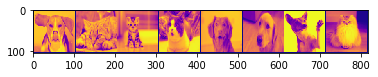

In [70]:
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images,normalize=True)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_cat_dog_images', img_grid)

## Inspect the model using tensorboard

In [71]:
writer.add_graph(cnn, images)
writer.close()

In [72]:
T = torch.zeros(size = (60,3,100,100))
Label = torch.zeros(dataset.__len__())
for i in range(dataset.__len__()):
    X,Y = dataset.__getitem__(i)
    T[i] = X
   # print(Y)
    Label[i] = Y
    

In [73]:
# helper function#
classes   = os.listdir(path)
def select_n_random(data, labels, n=60):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(T,Label)

# get the class labels for each image
class_labels = [classes[int(lab)] for lab in labels]

# log embeddings
features = images.view(-1,100*100*3)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

In [74]:
# helper functions

def images_to_probs(cnn, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = cnn(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(cnn, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(cnn, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [75]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    running_loss = 0.0
    for batch_idx,( data,target) in enumerate(dataloader):
        
#         # permute pixels
#         data = data.view(1,-1, 100*100)
#         data = data[:, perm]
       # inputs, target = data
        data = data.view(-1,3, 100, 100)
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
             # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 10,
                            epoch * len(dataloader) + batch_idx)
            running_loss = 0.0
            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
                       
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
#         # permute pixels
#         data = data.view(1,-1, 100*100)
#         data = data[:, perm]
        data = data.view(-1,3, 100, 100)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))


In [77]:
import torch.optim as optim
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np


n_hidden = 8 # number of hidden units
input_size  = 100*100  # images are 28x28 pixels
output_size = 2  

model_fnn = CNN(input_size, n_hidden, output_size)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
#print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0,10):
    train(epoch, model_fnn)